<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EA%B8%B0%EA%B3%84%EC%8B%9C%EC%84%A4%EB%AC%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 구조

2020-02-125.기계시설물고장예지_sample

> current
>>2.2kW
>>>L-DSF-01 정상, 축정렬불량  
>>>L-EF-04 정상, 회전체불평형  
>>>L-SF-04 정상, 베어링불량  
>>>R-EF-05 정상, 벨트느슨함  

>>55kW  
>>>L-PAHU-03S 정상, 회전체불평형  
>>>R-PAHU-04S 정상, 벨트느슨함  

>vibration
>>2.2kW  
>>55kW

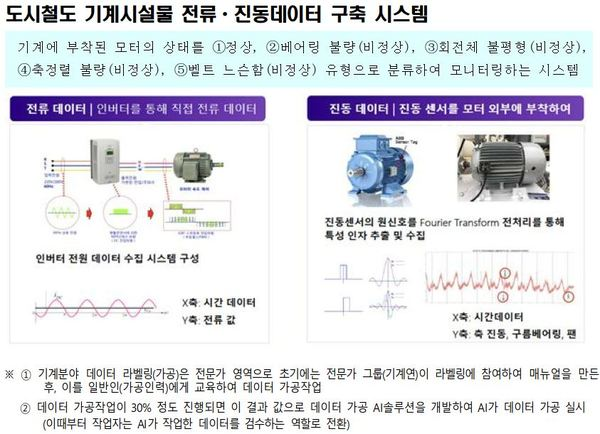

In [ ]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"
drive = '/content/gdrive/MyDrive/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## [벨로그 스터디](https://velog.io/@jonghne/LSTM-AE%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B4%EC%83%81-%ED%83%90%EC%A7%80-2-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC)

데이터 저장

In [ ]:
def load(num=1):

  corv='current'
  if num not in [1,2,3]: return None

  df_정상=pd.DataFrame()
  df_고장=pd.DataFrame()
  
  i=1
  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)

          types=unicodedata.normalize('NFC', types)

          if types=='정상': df_정상=pd.concat([df_정상, tmp[num]], axis=1) #추가
          else: df_고장=pd.concat([df_고장, tmp[num]], axis=1) #추가

          if i==1:
            res=machine+' '+types 
            print(i, res)
          elif res!=machine+' '+types: 
            res=machine+' '+types
            print(i, res)
          i+=1

  return df_정상, df_고장

In [ ]:
a, b = load(1)

1 L-DSF-01 축정렬불량
365 L-DSF-01 정상
462 L-SF-04 정상
539 L-SF-04 베어링불량
739 L-EF-04 회전체불평형
968 L-EF-04 정상
1635 R-EF-05 벨트느슨함
1821 R-EF-05 정상


In [ ]:
print(a.shape)
a.head()

(2000, 906)


,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0,-0.640625,2.802734,-3.283203,0.800781,0.0,-0.120117,0.0,0.0,-2.722656,0.520508,...,-2.322266,-1.921875,-0.480469,-0.600586,-1.281250,-1.801758,-1.121094,-1.000977,-0.080078,-2.602539
1,0.040039,2.922852,-3.203125,0.360352,0.0,-0.120117,0.0,0.0,-2.762695,0.120117,...,-1.921875,-1.521484,0.120117,0.000000,-0.920898,-1.441406,-0.640625,-0.520508,0.600586,-2.242188
2,0.720703,3.123047,-2.722656,-0.280273,0.0,-0.160156,0.0,0.0,-2.802734,-0.520508,...,-1.561523,-1.121094,0.760742,0.720703,-0.360352,-0.960938,-0.080078,0.120117,1.121094,-1.921875
3,1.561523,3.163086,-2.122070,-1.081055,0.0,-0.160156,0.0,0.0,-3.002930,-1.321289,...,-1.161133,-0.640625,1.241211,1.281250,0.200195,-0.560547,0.640625,0.600586,1.561523,-1.561523
4,2.122070,3.083008,-1.441406,-1.801758,0.0,-0.200195,0.0,0.0,-3.123047,-2.041992,...,-0.720703,0.000000,1.561523,1.761719,0.920898,0.080078,1.401367,1.121094,1.921875,-1.121094


In [ ]:
print(b.shape)
b.head()

(2000, 979)


,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0,3.042969,3.283203,-2.962891,3.163086,2.802734,-0.800781,0.400391,-2.402344,-1.521484,3.163086,...,3.002930,3.083008,-1.641602,-2.882812,-2.722656,3.163086,3.323242,2.482422,2.562500,-2.402344
1,3.243164,3.042969,-2.962891,3.203125,2.842773,-0.400391,1.201172,-2.882812,-1.041016,2.682617,...,3.363281,3.283203,-1.121094,-3.363281,-3.083008,3.443359,3.523438,2.722656,2.882812,-2.562500
2,3.323242,2.522461,-3.163086,3.163086,2.962891,0.160156,2.082031,-2.922852,-0.640625,2.162109,...,3.523438,3.523438,-0.640625,-3.603516,-3.243164,3.523438,3.363281,3.002930,3.163086,-3.083008
3,3.443359,1.921875,-3.203125,2.642578,3.163086,0.920898,2.642578,-2.962891,-0.160156,1.521484,...,3.443359,3.523438,-0.160156,-3.723633,-3.403320,3.363281,3.042969,3.283203,3.323242,-3.403320
4,3.042969,1.361328,-3.283203,2.162109,3.283203,1.641602,3.002930,-3.203125,0.480469,1.041016,...,3.123047,3.243164,0.600586,-3.723633,-3.243164,3.163086,2.842773,3.443359,3.243164,-3.563477


In [ ]:
a.to_pickle(os.path.join(drive, '전류정상.pkl'))
b.to_pickle(os.path.join(drive, '전류고장.pkl'))

### 1.혜연

### 2.수빈

#### 데이터 전처리

데이터는 1초에 2000개씩 측정됨

In [ ]:
a=pd.read_pickle(os.path.join(drive, '전류정상.pkl')).transpose()
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl')).transpose()

a

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1,-0.640625,0.040039,0.720703,1.561523,2.122070,2.562500,2.762695,2.722656,2.882812,3.083008,...,-2.802734,-2.962891,-3.163086,-3.243164,-3.163086,-2.762695,-2.242188,-1.681641,-1.201172,-0.800781
1,2.802734,2.922852,3.123047,3.163086,3.083008,2.682617,2.162109,1.561523,1.121094,0.680664,...,-2.362305,-1.841797,-1.281250,-0.840820,-0.440430,0.120117,0.840820,1.561523,2.202148,2.682617
1,-3.283203,-3.203125,-2.722656,-2.122070,-1.441406,-1.000977,-0.600586,-0.280273,0.400391,1.201172,...,-0.160156,-0.880859,-1.681641,-2.442383,-2.762695,-2.842773,-2.722656,-2.722656,-2.922852,-3.203125
1,0.800781,0.360352,-0.280273,-1.081055,-1.801758,-2.322266,-2.642578,-2.722656,-2.722656,-2.882812,...,2.722656,2.842773,2.842773,3.002930,3.163086,3.243164,3.163086,2.682617,2.041992,1.441406
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,-1.801758,-1.441406,-0.960938,-0.560547,0.080078,0.720703,1.401367,1.881836,2.162109,2.562500,...,-1.161133,-1.481445,-1.961914,-2.402344,-2.602539,-2.842773,-2.922852,-2.922852,-2.842773,-2.682617
1,-1.121094,-0.640625,-0.080078,0.640625,1.401367,1.721680,2.122070,2.482422,2.842773,3.123047,...,-1.841797,-2.282227,-2.522461,-2.722656,-2.722656,-2.722656,-2.722656,-2.682617,-2.282227,-1.921875
1,-1.000977,-0.520508,0.120117,0.600586,1.121094,1.561523,2.001953,2.402344,2.562500,2.562500,...,-2.402344,-2.802734,-2.962891,-2.882812,-2.842773,-2.842773,-2.762695,-2.402344,-2.001953,-1.561523
1,-0.080078,0.600586,1.121094,1.561523,1.921875,2.362305,2.762695,2.882812,2.762695,2.682617,...,-2.562500,-2.722656,-2.722656,-2.762695,-2.842773,-2.722656,-2.562500,-2.242188,-1.801758,-1.441406


In [ ]:
plt.plot(np.array(b.iloc[0]))

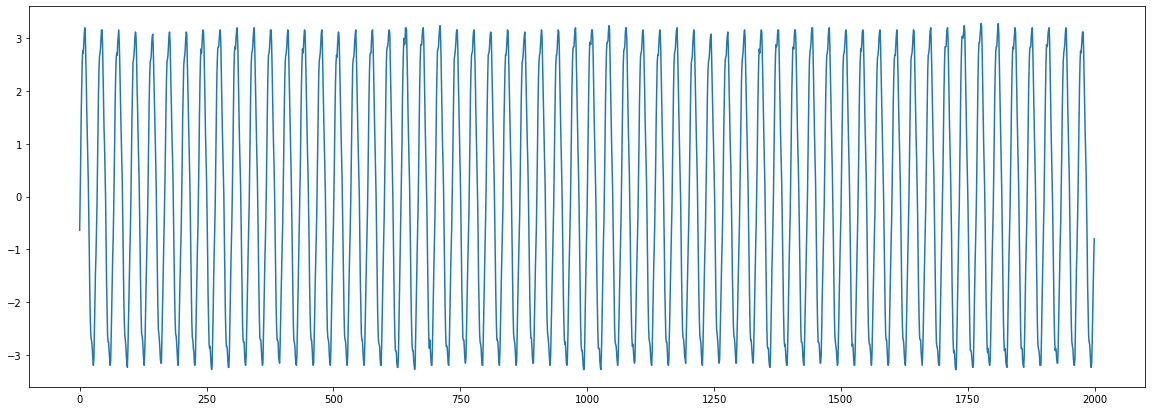

In [ ]:
plt.figure(figsize=(20,7))

plt.plot(np.array(a.iloc[0]))

## 3/2목

In [ ]:
#데이터 불러오기
a=pd.read_pickle(os.path.join(drive, '전류정상.pkl')).transpose()
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl')).transpose()

b=b.sample(frac=1).iloc[:906]

#테스트 데이터 만들기 (정상+고장)
a_=a.iloc[:,:1000].reset_index()
b_=b.iloc[:,:1000].reset_index()
ab=pd.concat([a_,b_], axis=1)
ab=ab.drop(columns=['index'])

#train/test 분리
a_train, a_test = a[:755], a[755:]
ab_test = ab[:151]

#테스트셋 만들기 (라벨도 포함)
a_test_tot = np.hstack((a_test, np.zeros(a_test.shape[0]).reshape(-1,1))) #라벨
ab_test_tot = np.hstack((ab_test, np.ones(ab_test.shape[0]).reshape(-1,1)))
test = np.vstack((a_test_tot, ab_test_tot))

#test/valid 분리
x_test, x_valid, y_test, y_valid = train_test_split(test[:,:-1], test[:,-1], test_size=0.3, random_state=0)

print('학습데이터')
print(a_train.shape)
print()

print('테스트데이터')
print(x_test.shape, y_test.shape)
print()

print('검증데이터')
print(x_valid.shape, y_valid.shape)
print()

학습데이터
(755, 2000)

테스트데이터
(211, 2000) (211,)

검증데이터
(91, 2000) (91,)



아래는 코드 짜던거

In [ ]:
a=pd.read_pickle(os.path.join(drive, '전류정상.pkl')).transpose()
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl')).transpose()

In [ ]:
b=b.sample(frac=1).iloc[:906]

In [ ]:
a_=a.iloc[:,:1000].reset_index()
b_=b.iloc[:,:1000].reset_index()

In [ ]:
new=pd.concat([a_,b_], axis=1)
new=new.drop(columns=['index'])

In [ ]:
new.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.640625,0.040039,0.720703,1.561523,2.122070,2.562500,2.762695,2.722656,2.882812,3.083008,...,-1.226196,-0.625610,-0.145142,0.535522,1.296265,2.057007,2.657593,2.937866,3.218140,3.338257
1,2.802734,2.922852,3.123047,3.163086,3.083008,2.682617,2.162109,1.561523,1.121094,0.680664,...,-0.990967,-0.270264,0.290283,1.010986,1.971924,2.852783,3.453369,3.653564,3.893799,3.973877
2,-3.283203,-3.203125,-2.722656,-2.122070,-1.441406,-1.000977,-0.600586,-0.280273,0.400391,1.201172,...,-4.714600,-4.794678,-4.634521,-4.274170,-3.793701,-3.273193,-2.272217,-1.111084,-0.230225,0.530518
3,0.800781,0.360352,-0.280273,-1.081055,-1.801758,-2.322266,-2.642578,-2.722656,-2.722656,-2.882812,...,-0.945923,-1.786743,-2.627563,-3.228149,-3.508423,-3.708618,-3.788696,-3.828735,-3.908813,-3.788696
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.213135,3.413330,3.533447,3.573486,3.573486,3.373291,3.293213,2.972900,2.172119,1.411377


In [ ]:
a.shape

(906, 2000)

In [ ]:
a_train, a_test = a[:755], a[755:]
b_test = new[:151]

In [ ]:
a_test_tot = np.hstack((a_test, np.zeros(a_test.shape[0]).reshape(-1,1))) #라벨
b_test_tot = np.hstack((b_test, np.ones(b_test.shape[0]).reshape(-1,1)))
test = np.vstack((a_test_tot, b_test_tot))

In [ ]:
#테스트 데이터셋 크기

print(test.shape) #라벨도 있음

(302, 2001)


In [ ]:
x_test, x_valid, y_test, y_valid = train_test_split(test[:,:-1], test[:,-1], test_size=0.3, random_state=0)

In [ ]:
#학습 데이터셋 크기

print(a_train.shape)

(755, 2000)


In [ ]:
#테스트/검증 데이터셋 크기

print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(211, 2000) (211,)
(91, 2000) (91,)


원래 코드

In [ ]:
#데이터 불러오기
a=pd.read_pickle(os.path.join(drive, '전류정상.pkl')).transpose()
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl')).transpose()

print(a.shape, b.shape)

#데이터 크기 맞추기
b=b.sample(frac=1).iloc[:906]

print(a.shape, b.shape)

#데이터 길이 맞추기
a=pd.DataFrame(np.array(a).reshape(1812, 1000))
b=pd.DataFrame(np.array(b).reshape(1812, 1000))

print(a.shape, b.shape)

#train/test 분리
a_train, a_test = a[:1208], a[1208:]
b_test = b[:604]

#test 데이터셋
a_test_tot = np.hstack((a_test, np.zeros(a_test.shape[0]).reshape(-1,1))) #라벨
b_test_tot = np.hstack((b_test, np.ones(b_test.shape[0]).reshape(-1,1)))
test = np.vstack((a_test_tot, b_test_tot))

#test/valid 분리
x_test, x_valid, y_test, y_valid = train_test_split(test[:,:-1], test[:,-1], test_size=0.3, random_state=0)

print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(906, 2000) (979, 2000)
(906, 2000) (906, 2000)
(1812, 1000) (1812, 1000)
(845, 1000) (845,)
(363, 1000) (363,)


아래거는 무시!!!

In [ ]:
#데이터 불러오기
a=pd.read_pickle(os.path.join(drive, '전류정상.pkl'))
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl'))

print(a.shape, b.shape)

#데이터 크기 맞추기
b=b.transpose().sample(frac=1).transpose().iloc[:,:906]

print(a.shape, b.shape)

#데이터 길이 맞추기
a=pd.DataFrame(np.array(a).reshape(4000, 453))
b=pd.DataFrame(np.array(b).reshape(4000, 453))

print(a.shape, b.shape)

(2000, 906) (2000, 979)
(2000, 906) (2000, 906)
(4000, 453) (4000, 453)


1. 훈련/검증/테스트 분리

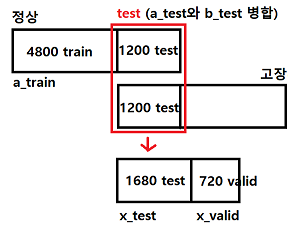

In [ ]:
#train/test 분리
a_train, a_test = a[:3200], a[3200:]
b_test = b[:800].iloc[:,:a_train.shape[1]]

#test 데이터셋
a_test_tot = np.hstack((a_test, np.zeros(a_test.shape[0]).reshape(-1,1))) #라벨
b_test_tot = np.hstack((b_test, np.ones(b_test.shape[0]).reshape(-1,1)))
test = np.vstack((a_test_tot, b_test_tot))

#test/valid 분리
x_test, x_valid, y_test, y_valid = train_test_split(test[:,:-1], test[:,-1], test_size=0.3, random_state=0)

print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(1120, 453) (1120,)
(480, 453) (480,)


2. 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

stder = StandardScaler()
stder.fit(a_train) #stder를 a_train에 맞춤

a_train_scaled = stder.transform(a_train)
x_valid_scaled = stder.transform(x_valid)
x_test_scaled = stder.transform(x_test)

print(a_train_scaled.shape)
print(x_valid_scaled.shape)
print(x_test_scaled.shape)

(755, 2000)
(91, 2000)
(211, 2000)


3. 스케일링

train/valid/test 데이터를 lstm 입력 형태로 맞추기 위해 3차원으로 차원을 변경함

In [ ]:
# 복잡해 보이는거지 간단함

# X_scaled = X.reshape( X.shape[0], 1, X.shape[1] )

a_train_scaled = a_train_scaled.reshape(a_train_scaled.shape[0], 1, a_train_scaled.shape[1])
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])

print(a_train_scaled.shape)
print(x_valid_scaled.shape)
print(x_test_scaled.shape)

(755, 1, 2000)
(91, 1, 2000)
(211, 1, 2000)


#### 모델 구현

2개의 인코더와 2개의 디코더로 구성됨

In [ ]:
from keras import regularizers
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model

def AE(x):
  inputs = Input(shape=(x.shape[1], x.shape[2]))

  L1=LSTM(140, activation='relu', return_sequences=True,
          kernel_regularizer=regularizers.l2(0.00))(inputs)

  L2=LSTM(70, activation='relu', return_sequences=False)(L1)

  L3=RepeatVector(x.shape[1])(L2)

  L4=LSTM(70, activation='relu', return_sequences=True)(L3)

  L5=LSTM(140, activation='relu', return_sequences=True)(L4)

  output = TimeDistributed(Dense(x.shape[2]))(L5)

  model = Model(inputs=inputs, outputs=output)

  return model

In [ ]:
#모델 생성하고 컴파일

from keras.optimizers import Adam

model = AE(a_train_scaled)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 2000)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 140)            1198960   
                                                                 
 lstm_5 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_7 (LSTM)               (None, 1, 140)            118160    
                                                           

#### 모델 학습

6분 걸림

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(a_train_scaled, a_train_scaled, epochs=100,
                    batch_size=16, validation_data=(x_valid_scaled, x_valid_scaled),
                    callbacks=callbacks)

Epoch 1/100
48/48 [==============================] - 8s 51ms/step - loss: 1.0000 - val_loss: 0.8568
Epoch 2/100
48/48 [==============================] - 1s 29ms/step - loss: 0.9321 - val_loss: 0.7565
Epoch 3/100
48/48 [==============================] - 1s 21ms/step - loss: 0.5361 - val_loss: 0.4818
Epoch 4/100
48/48 [==============================] - 1s 24ms/step - loss: 0.1595 - val_loss: 0.2813
Epoch 5/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0366 - val_loss: 0.2672
Epoch 6/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0278 - val_loss: 0.2642
Epoch 7/100
48/48 [==============================] - 1s 20ms/step - loss: 0.0255 - val_loss: 0.2632
Epoch 8/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0242 - val_loss: 0.2617
Epoch 9/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0237 - val_loss: 0.2612
Epoch 10/100
48/48 [==============================] - 1s 19ms/step - loss: 0.0232 - val_loss: 0.2607

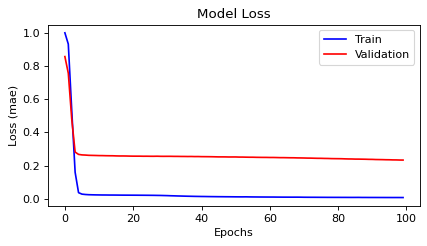

In [ ]:
fig, ax = plt.subplots(figsize=(6,3), dpi=80)

ax.plot( history.history['loss'], 'b', label='Train' )
ax.plot( history.history['val_loss'], 'r', label='Validation' )

ax.set_title('Model Loss')
ax.set_xlabel('Epochs'); ax.set_ylabel('Loss (mae)')
ax.legend(loc='upper right')

plt.show()

In [ ]:
#다시 차원 축소
pred_3d = model.predict(x_valid_scaled)
pred = pred_3d.reshape(pred_3d.shape[0], pred_3d.shape[2])
x_valid_ = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[2])

mse=np.mean(np.power(x_valid_ - pred, 2), axis=1)

3/3 [==============================] - 1s 13ms/step


In [ ]:
df_error=pd.DataFrame({'Reconstruction_error': mse,
                       'True_class': y_valid})

In [ ]:
df_error

,Reconstruction_error,True_class
0,0.759071,1.0
1,0.803816,1.0
2,0.092133,1.0
3,0.792441,1.0
4,0.010839,0.0
...,...,...
86,0.071008,1.0
87,0.439587,1.0
88,0.012391,0.0
89,0.350812,1.0


In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve

pre, re, thres = metrics.precision_recall_curve(df_error['True_class'], df_error['Reconstruction_error'])

best=abs(pre-re)
best=np.argmin(best)

print('precision:', pre[best], ', recall:', re[best])
print('threshold:', thres[best])

precision: 1.0 , recall: 1.0
threshold: 0.01487055669665974


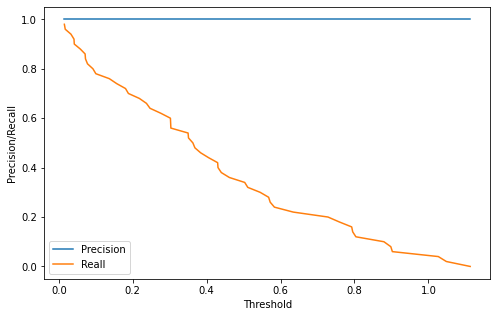

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(thres, pre[1:], label='Precision')
plt.plot(thres, re[1:], label='Reall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

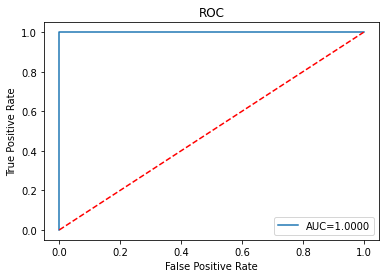

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, mse)
roc_auc=auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, label='AUC=%0.4f' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
test_pred_3d = model.predict(x_test_scaled)
test_pred = test_pred_3d.reshape(test_pred_3d.shape[0], test_pred_3d.shape[2])

mse = np.mean(np.power(x_test_scaled - test_pred, 2), axis=1)

7/7 [==============================] - 0s 9ms/step


### 3.세희

## 1.데이터프레임 만들고 csv로 저장하기 (저장했으면 X)

load 함수
- x데이터 만드는 함수
- 모든 csv파일 불러와서 하나의 data frame으로 저장함 (변수: df)

label 함수
- y데이터 만드는 함수
- 각 csv파일 개수 가져와서 고장유형을 라벨링하는 array로 저장함 (변수: arr)
- 정상(0), 베어링불량(1), 벨트느슨함(2), 축정렬불량(3), 회전체불평형(4)

corv 파라미터
- current 또는 vibration

xc, yc, xv, yv 변수
- current와 vibration의 x데이터와 y데이터


In [ ]:
def load(corv):
  if corv not in ['current','vibration']: return None
  df=pd.DataFrame() #빈 데이터프레임 만들기
  i=1 #몇번째 저장중인지 알려주는 변수

  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          
          #csv파일 읽어서 tmp에 저장
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)

          #필요없는 열 삭제
          if corv=='current':
            tmp=tmp.drop([0, 4],axis=1)
          elif corv=='vibration':
            tmp=tmp.drop([0, 2],axis=1)

          #전치하고 df에 이어붙임
          tmp=tmp.transpose()
          df=pd.concat([df, tmp])

          #machine이랑 type이 바뀔 때마다 몇번째 저장중인지 같이 출력함
          if i==1:
            res=machine+' '+types #res에 저장
            print(i, res)
          elif res!=machine+' '+types: #res랑 다르면 지금걸로 업데이트
            res=machine+' '+types
            print(i, res)
          i+=1
  df=df.reset_index().drop(['index'], axis=1) #완성된 데이터프레임 인덱스 초기화하기 (자동으로 생기는 열도 삭제함)
  return df


def label(corv):
  if corv not in ['current','vibration']: return None #다른 거 입력하면 None 반환
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):

      #유니코드가 다르면 문자열 비교가 안됨 그거 잡아주는 코드임
      types=unicodedata.normalize('NFC', types)

      #csv파일 개수 저장함
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3 #전류데이터일 때만 3배 해줌

      #types에 따라 라벨 만듦
      if types=='정상': tmp=np.zeros(mylen) #정상이면 0으로 채워진 array
      elif '베어링' in types: tmp=np.ones(mylen)*1 #베어링 포함돼있으면 1로 채워진 array
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4

      #arr에 이어붙임 (단, 맨처음에는 arr이 없으니까 대입함)
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
      
  return arr


In [ ]:
5655 -> [2718, 600, 558, 1092, 687]

In [ ]:
#함수 호출해서 x데이터랑 라벨데이터 저장함

xc=load('current')
xv=load('vibration')

yc=label('current')
yv=label('vibration')


1 L-DSF-01 축정렬불량
365 L-DSF-01 정상
462 L-SF-04 정상
539 L-SF-04 베어링불량
739 L-EF-04 회전체불평형
968 L-EF-04 정상
1635 R-EF-05 벨트느슨함
1821 R-EF-05 정상
1 L-EF-04 정상
421 L-EF-04 회전체불평형
626 R-EF-05 벨트느슨함
819 R-EF-05 정상
895 L-SF-04 정상
979 L-SF-04 베어링불량
1219 L-DSF-01 축정렬불량
1426 L-DSF-01 정상


In [ ]:
#x데이터를 드라이브에 csv파일로 저장함

xc.to_csv('/content/gdrive/MyDrive/CURRENT.csv')
xv.to_csv('/content/gdrive/MyDrive/VIBRATION.csv')


In [ ]:
xc.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,3.042969,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
1,-1.361328,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
2,-2.762695,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789


In [ ]:
#x데이터는 데이터프레임이니까 shape를 확인하고
#y데이터는 array니까 len을 확인함

print("x데이터 구조:", xc.shape, xv.shape)
print("y데이터 분포:", len(yc), '->', [list(yc).count(i) for i in range(5)])
print("             ", len(yv), '->', [list(yv).count(i) for i in range(5)])


x데이터 구조: (5655, 2000) (1525, 12000)
y데이터 분포: 5655 -> [2718, 600, 558, 1092, 687]
              1525 -> [680, 240, 193, 207, 205]


## 2.y데이터 만들기 (1 실행했거나 pickle 저장했으면 X)

In [ ]:
def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3

      if types=='정상': tmp=np.zeros(mylen)
      elif '베어링' in types: tmp=np.ones(mylen)*1
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

yc=label('current')
yv=label('vibration')

In [ ]:
#데이터프레임 불러오기
raw=pd.read_csv('/content/gdrive/MyDrive/CURRENT.csv', index_col=0)

#라벨 추가하기
raw['label']=pd.DataFrame(yc)

#데이터셋 훈련, 검증, 테스트 분리하기
train, valid = train_test_split(raw, test_size=0.40, random_state=0, shuffle=True)
valid, test = train_test_split(valid, test_size=0.50, random_state=0, shuffle=True)

#데이터셋 x와 y 분리하기
train_x=train.iloc[:,:-1] #모든행, 라벨은 빼고
valid_x=valid.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=train.iloc[:,-1] #모든행, 라벨만
valid_y=valid.iloc[:,-1]
test_y=test.iloc[:,-1]

#피클로 저장하기
train_x.to_pickle(os.path.join(drive, 'xtrain.pkl')) #x피클
valid_x.to_pickle(os.path.join(drive, 'xvalid.pkl'))
test_x.to_pickle(os.path.join(drive, 'xtest.pkl'))
train_y.to_pickle(os.path.join(drive, 'ytrain.pkl')) #y피클
valid_y.to_pickle(os.path.join(drive, 'yvalid.pkl'))
test_y.to_pickle(os.path.join(drive, 'ytest.pkl'))

## 3.x데이터 불러와서 split하고 pickle로 저장하기 (일단 전류만)

In [ ]:
#데이터프레임 불러오기
raw=pd.read_csv('/content/gdrive/MyDrive/CURRENT.csv', index_col=0)

#라벨 추가하기
raw['label']=pd.DataFrame(yc)

#데이터셋 훈련, 검증, 테스트 분리하기
train, valid = train_test_split(raw, test_size=0.40, random_state=0, shuffle=True)
valid, test = train_test_split(valid, test_size=0.50, random_state=0, shuffle=True)

#데이터셋 x와 y 분리하기
train_x=train.iloc[:,:-1] #모든행, 라벨은 빼고
valid_x=valid.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=train.iloc[:,-1] #모든행, 라벨만
valid_y=valid.iloc[:,-1]
test_y=test.iloc[:,-1]

#피클로 저장하기
train_x.to_pickle(os.path.join(drive, 'xtrain.pkl')) #x피클
valid_x.to_pickle(os.path.join(drive, 'xvalid.pkl'))
test_x.to_pickle(os.path.join(drive, 'xtest.pkl'))
train_y.to_pickle(os.path.join(drive, 'ytrain.pkl')) #y피클
valid_y.to_pickle(os.path.join(drive, 'yvalid.pkl'))
test_y.to_pickle(os.path.join(drive, 'ytest.pkl'))


In [ ]:
print(train.shape, '->', train_x.shape, train_y.shape)
print(valid.shape, '->', valid_x.shape, valid_y.shape)
print(test.shape, '->', test_x.shape, test_y.shape)

(3393, 2001) -> (3393, 2000) (3393,)
(1131, 2001) -> (1131, 2000) (1131,)
(1131, 2001) -> (1131, 2000) (1131,)


## pickle 불러오기

pick 함수

- 가공된 피클 3개를 한번에 반환하는 함수
- 파라미터로 'X'나 'Y'를 입력


In [ ]:
def pick(xory, tensor=0):

  #x를 입력하면 x피클 3개,
  #y를 입력하면 y피클 3개의 이름을 변수에 저장함
  if xory in ['X','x']: pickles=['xtrain.pkl','xvalid.pkl','xtest.pkl']
  elif xory in ['Y','y']: pickles=['ytrain.pkl','yvalid.pkl','ytest.pkl']
  else: return None

  res=[] #데이터 담을 빈 리스트 만듦

  for i in pickles:
    tmp=pd.read_pickle(os.path.join(drive, i)) #변수에서 하나씩 뽑아서 피클 불러옴
    if tensor==0:
      tmp=torch.from_numpy(tmp.values) #텐서 변환
      tmp=torch.unsqueeze(tmp, 1) #차원 증가

    res.append(tmp) #가공한 피클을 리스트에 추가함

  return res[0], res[1], res[2] #하나씩 반환함

In [ ]:
#함수 호출해서 x피클이랑 y피클 불러옴

X_train, X_valid, X_test=pick('X')
Y_train, Y_valid, Y_test=pick('Y')


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

torch.Size([3393, 1, 2000]) torch.Size([3393, 1])
torch.Size([1131, 1, 2000]) torch.Size([1131, 1])
torch.Size([1131, 1, 2000]) torch.Size([1131, 1])


# ㅡㅡㅡㅡㅡㅡ 참고 주석 ㅡㅡㅡㅡㅡㅡ

## 2/8수

1.데이터셋 만들기 완료

label 함수 수정해서 yc 길이를 xc 크기에 맞춰줬음

x데이터 csv로 불러와서 train_test_split 하기 전에 y데이터 이어붙임


---



2.pickle로 저장하기 완료 

pandas에 to_pickle 이랑 read_pickle 함수가 있음

각각 데이터프레임->피클, 피클->데이터프레임 변환하는 거임

그래서, 세희가 알려준 데이터프레임->어레이->텐서->피클로 저장 방식은 구현 못했고

데이터프레임->피클로 저장 후 데이터프레임->어레이->텐서는 가능함

```
#train_x를 xtrain.pkl로 변환해서 drive에 저장
train_x.to_pickle(os.path.join(drive, 'xtrain.pkl'))

#train_pkl를 불러와서 변수에 저장
X_train=pd.read_pickle(os.path.join(drive, 'xtrain.pkl'))
```

drive는 내가 만든 변수임 (구글드라이브 주소)

--- 
3.pickle 불러오기 완료

이건 함수 만들어서 구현했으니 목차에서 확인해줘







### 4줄 추가함
피클 저장할 드라이브 주소임

### 22줄, 32줄 추가함

```df.reset_index().drop(['index'], axis=1)```

tmp를 이어 붙여서 완성한 df의 행 헤더는 123 123 123 이렇게 돼  
그래서 012 345 678 로 바꾸려고 인덱스 리셋하고, 리셋하면 자동으로 생기는 index열 삭제했어 (아래 사진 참고)  
인덱스 리셋한 이유는 행 인덱싱 불편한 것도 있지만  
데이터셋 split 하기 전에 x데이터에 y데이터 이어 붙이잖아 그때 인덱스 다르다고 오류 나더라고


```if corv='currnet': mylen=mylen*3```

이게 vibration은 상관 없는데 current는 엑셀에서 열이 3개였잖아 (각각 xyz)

이거 때문에 데이터 1개가 df에 행 3개로 저장돼서

라벨도 3개씩 넣어줘야 해

그래서 current일 때만 고장유형 개수 세는 변수인 mylen에 3 곱해줬어

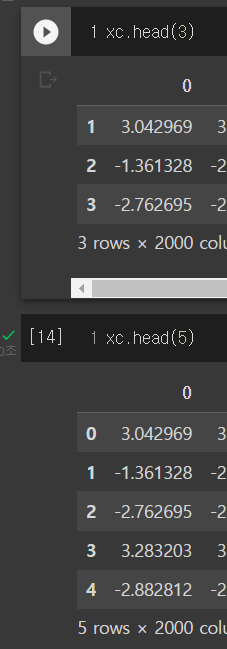

### 전체적으로 수정함

아래 주석처리 한 코드 보면...

위에는 우리 줌할 때 세희가 알려준 코드 결과야  
**데이터셋 split-> x,y 분리-> 텐서로 변환한** 거고

나는 텐서를 피클로 바꾸는 방법을 영 못찾아서

아래처럼 데이터셋 split한 다음에 x,y 분리하고 **데이터프레임 상태 그대로** 피클에 저장했어

이제 피클로 불러올 수는 있는데, ~~문제는 **텐서로 변환하는 작업**을 따로 또 해야 돼~~

***그래서 <피클 불러오기+텐서 변환하기> 기능을 하는 pick 함수를 새로 만들었어...  
아래에서 확인해줘...***


### 함수 만듦

함수 덕분에 단 두줄로 피클 6개를 모델에 바로 쓸 수 있게 불러올 수 있어

함수 없으면 이렇게 했어야 했어

```
#피클 불러오기 6번
X_train=pd.read_pickle(os.path.join(drive, 'xtrain.pkl'))
X_valid=pd.read_pickle(os.path.join(drive, 'xvalid.pkl'))
X_test=pd.read_pickle(os.path.join(drive, 'xtest.pkl'))
...

#토치로 변환하고 차원 증가하기 6번까지...
X_train=torch.unsqueeze( torch.from_numpy(X_train.values), 1 )
X_valid=torch.unsqueeze( torch.from_numpy(X_valid.values), 1 )
X_test=torch.unsqueeze( torch.from_numpy(X_test.values), 1 )
...
```

# ㅡㅡㅡㅡㅡㅡ 옛날 코드 ㅡㅡㅡㅡㅡㅡ

## 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(machine)

L-DSF-01
L-SF-04
L-EF-04
R-EF-05


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(os.listdir(file_path+'current/2.2kW/'+machine))

['축정렬불량', '정상']
['정상', '베어링불량']
['회전체불평형', '정상']
['벨트느슨함', '정상']


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
  for types in os.listdir(file_path+'current/2.2kW/'+machine):
    print(len(os.listdir(file_path+'current/2.2kW/'+machine+'/'+types)))

364
97
77
200
229
667
186
65


## x데이터

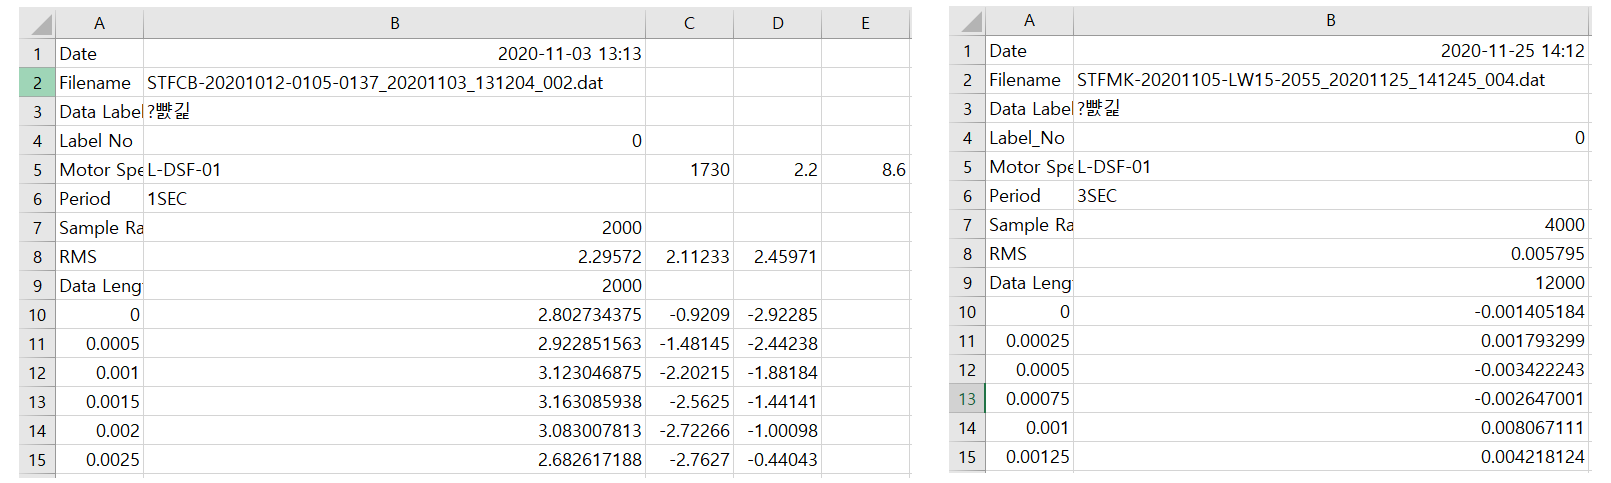

- df: 모든 csv파일 데이터를 담을 최종 data frame임
- - dfc: current
- - dfv: vibration
- i: 몇번째 저장 중인지 알려주는 인덱스임
- machine: 기계이름 가져옴
- types: 고장유형 가져옴
- files: 파일이름 가져옴
- tmp: csv파일 하나를 읽어와서 임시 저정하는 변수임, 9행까지는 skip함, 필요 없는 행 드롭함, 행열 뒤집음
- - dfc에서는 0열과 4열을 삭제
- - dfv에서는 0열과 2열을 삭제
- df: df에 tmp 결합함
- if: 실행확인을 위해 100 단위로 인덱스 출력함

In [ ]:
df=pd.DataFrame()
i=1 

for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    for files in os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types):
      tmp=pd.read_csv(file_path+'/current/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9)
      tmp=tmp.drop(['0','Unnamed: 4'],axis=1)
      tmp=tmp.transpose()
      df=pd.concat([df, tmp])
      if i%100==0: print(i, machine, types)
      i+=1

100 L-DSF-01 축정렬불량
200 L-DSF-01 축정렬불량
300 L-DSF-01 축정렬불량
400 L-DSF-01 정상
500 L-SF-04 정상
600 L-SF-04 베어링불량
700 L-SF-04 베어링불량
800 L-EF-04 회전체불평형
900 L-EF-04 회전체불평형
1000 L-EF-04 정상
1100 L-EF-04 정상
1200 L-EF-04 정상
1300 L-EF-04 정상
1400 L-EF-04 정상
1500 L-EF-04 정상
1600 L-EF-04 정상
1700 R-EF-05 벨트느슨함
1800 R-EF-05 벨트느슨함


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
3.04296875,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,-0.240234,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
-1.361328125,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,-2.322266,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
-2.7626953125,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,2.842773,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789
3.283203125,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,-2.242188,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
-2.8828125,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,-0.640625,...,2.842773,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.5224609375,1.961914,1.561523,1.000977,0.600586,0.040039,-0.640625,-1.321289,-1.641602,-2.082031,-2.602539,...,-0.480469,0.120117,0.600586,1.081055,1.521484,1.921875,2.322266,2.522461,2.562500,2.522461
-2.8828125,-3.042969,-3.083008,-3.002930,-2.882812,-2.762695,-2.602539,-1.961914,-1.561523,-1.081055,-0.600586,...,2.402344,1.961914,1.561523,1.201172,0.760742,0.280273,-0.280273,-0.800781,-1.241211,-1.601562
-2.6025390625,-2.242188,-1.921875,-1.561523,-1.121094,-0.600586,0.000000,0.640625,1.121094,1.561523,2.041992,...,-0.920898,-1.561523,-1.961914,-2.402344,-2.762695,-2.922852,-3.163086,-3.163086,-3.163086,-2.922852
2.162109375,2.402344,2.562500,2.682617,2.722656,2.522461,2.242188,1.921875,1.401367,1.081055,0.600586,...,-2.402344,-1.801758,-1.361328,-0.960938,-0.480469,0.240234,0.840820,1.521484,1.921875,2.242188


In [ ]:
df.to_csv('/content/gdrive/MyDrive/current.csv')

##
## df를 csv로 바꿔서 드라이브에 최종저장하는 것임!!! 한번만 실행!!!
##

## y데이터

- arr: 라벨 데이터를 담을 최종 array임
- mylist: 고장유형이랑 파일개수를 순서대로 저장하는 리스트임
- types: 아래의 오류 때문에 unicode 변환함
- - 오류: 한글이 같은데 == 결과가 false가 나옴, type은 str인데 1로 인덱싱 하니 첫글자가 아니라 자음이 나옴
- - 해결: https://jonsyou.tistory.com/26
- mylen
- for: step을 2로 해서 mylist에서 고장유형만 가져옴
- if: 고장유형이 정상이면 np.zeros()를 써서 0이 파일개수만큼 있는 array를 tmp에 저장함
- elif: 고장유형이 고장이면 np.ones()를 써서 1,2,3,4가 파일개수만큼 있는 array를 tmp에 저장함
-if: 첫번째면 arr에 tmp 대입함 (arr가 없기 때문에 아래 코드 쓰면 오류남)
-else: 아니면 arr에 tmp 이어붙이고 arr에 저장함

In [ ]:
mylist=[]
for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    types=unicodedata.normalize('NFC', types)
    mylen=len(os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types))
    mylist.append(str(types))
    mylist.append(mylen)

print(mylist)

['축정렬불량', 364, '정상', 97, '정상', 77, '베어링불량', 200, '회전체불평형', 229, '정상', 667, '벨트느슨함', 186, '정상', 65]


In [ ]:
for i in range(0,len(mylist),2):
  print(i, mylist[i])
  if mylist[i]=='정상': tmp=np.zeros(mylist[i+1])
  elif '베어링' in mylist[i]: tmp=np.ones(mylist[i+1])*1
  elif '벨트' in mylist[i]: tmp=np.ones(mylist[i+1])*2
  elif '축' in mylist[i]: tmp=np.ones(mylist[i+1])*3
  elif '회전체' in mylist[i]: tmp=np.ones(mylist[i+1])*4
  if i==0: arr=tmp
  else: arr=np.hstack([arr,tmp])

0 축정렬불량
2 정상
4 정상
6 베어링불량
8 회전체불평형
10 정상
12 벨트느슨함
14 정상


In [ ]:
arr[300:600]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

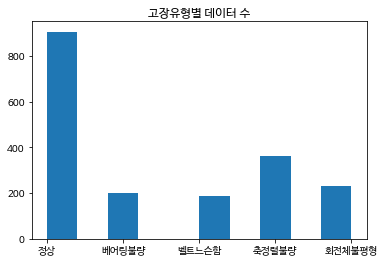

[906, 200, 186, 364, 229]

In [ ]:
plt.hist(list(arr))
plt.rc('font', family='NanumBarunGothic')
plt.title('고장유형별 데이터 수')
plt.xticks(range(5), ['정상','베어링불량','벨트느슨함','축정렬불량','회전체불평형'])
plt.show()

[list(arr).count(i) for i in range(5)]

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(df, arr, test_size=0.3, random_state=0)
